# Exercise: 
1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.
2. Forecast, plot and evaluate using each at least 4 of the methods we discussed:
    - Last Observed Value
    - Simple Average
    - Moving Average
    - Holt's Linear Trend
    - Holt's Seasonal Trend
    - Based on previous year/month/etc., this is up to you.

Bonus:
1. Using the store item demand data, create a forecast of sales_total and quantity for 2018 using the Previous Cycle approach. .
2. Predict 2018 total monthly sales for a single store and/or item by creating a model using prophet.
3. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
4. Plot the 2018 monthly sales predictions.

In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# wrangle
from env import user, password, host
import os

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

In [2]:
df = pd.read_csv('saas.csv')

In [3]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [5]:
# make columns lowercase: 
df.columns = df.columns.str.lower()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   month_invoiced     790458 non-null  object 
 1   customer_id        790458 non-null  int64  
 2   invoice_id         790458 non-null  int64  
 3   subscription_type  790458 non-null  float64
 4   amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [7]:
# change the index to datetime: 
df['month_invoiced'] = pd.to_datetime(df['month_invoiced'])

In [8]:
# set and sort the index: 
df = df.set_index('month_invoiced').sort_index()

In [9]:
df.head()

,customer_id,invoice_id,subscription_type,amount
month_invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0


In [10]:
# add a column for date, and year
#df['year'] = df.index.year
#df['month'] = df.index.month_name()

In [11]:
# day of the week: 
#df['day'] = df.index.day_name()

In [12]:
df.head()

,customer_id,invoice_id,subscription_type,amount
month_invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0


In [13]:
df.index.min(), df.index.max()

(Timestamp('2014-01-31 00:00:00'), Timestamp('2017-12-31 00:00:00'))

In [14]:
#look for leap years: 
leap_year = (df.index.month == 2) & (df.index.day == 29)

In [15]:
leap_days = df[leap_year]
leap_days

,customer_id,invoice_id,subscription_type,amount
month_invoiced,,,,
2016-02-29,1000000,5448036,1.0,5.0
2016-02-29,1000003,5448037,0.0,0.0
2016-02-29,1000004,5448038,1.0,5.0
2016-02-29,1000007,5448039,0.0,0.0
2016-02-29,1000009,5448040,0.0,0.0
...,...,...,...,...
2016-02-29,1024995,5464050,0.0,0.0
2016-02-29,1024996,5464051,0.0,0.0
2016-02-29,1024997,5464052,0.0,0.0


In [16]:
leap_days.groupby(leap_days.index).sum()

,customer_id,invoice_id,subscription_type,amount
month_invoiced,,,,
2016-02-29,16230363306,87400384855,10391.0,51955.0


In [17]:
# remove the leap year: 
df_clean = df[df.index != '2016-02-29']

In [18]:
# resample the data: 
df_resample = df.resample('M')[['amount']].sum()

# Split
- We will use the training proportion method to split.
- Identify the total length of the dataframe and multiple by train_prop to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data. (x = train_prop * 100)
- Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.
- Return train and test dataframes.

In [19]:
# train = 50%
train_size = int(.5 * len(df_resample))

# validate = 30%
validate_size = int(.3 * len(df_resample))

#test = remainder:
test_size = int(len(df_resample) - train_size - validate_size)

# get the delineation point between validate and test by summing train and validate
validate_end_index = train_size + validate_size

In [20]:
# split the data: 
train = df_resample[:train_size]

validate = df_resample[train_size:validate_end_index]

test = df_resample[validate_end_index:]

In [21]:
# double check that the sizes match
df_resample.shape

(48, 1)

In [22]:
train.shape[0] + validate.shape[0] + test.shape[0]

48

# Visualizing the data

In [23]:
train

,amount
month_invoiced,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0
2014-06-30,41255.0
2014-07-31,42170.0
2014-08-31,43210.0
2014-09-30,44075.0


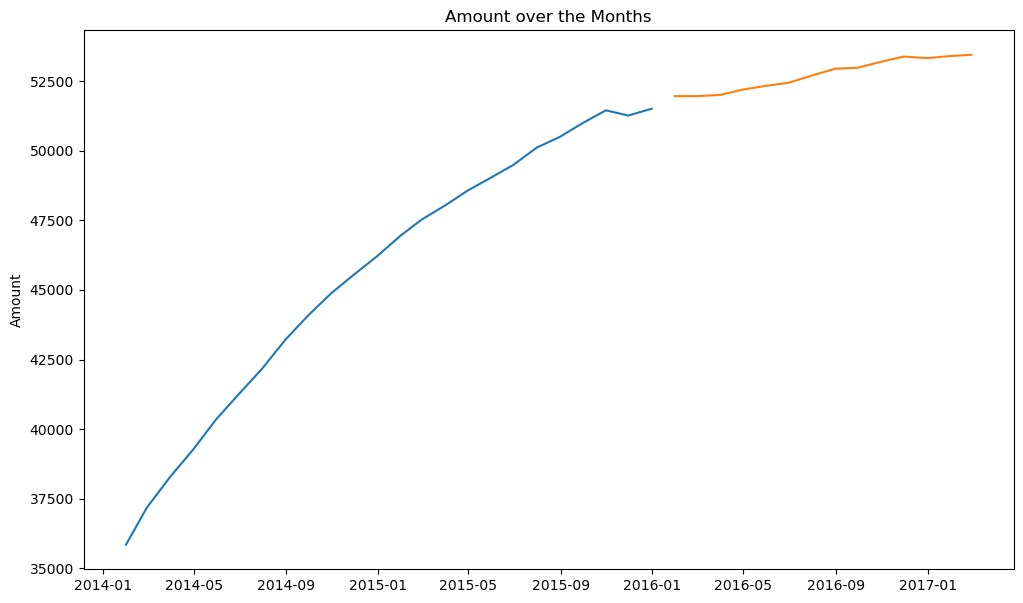

In [24]:
plt.figure(figsize = (12,7))
plt.plot(train.amount)
plt.plot(validate.amount)
plt.ylabel('Amount')
plt.title('Amount over the Months')
plt.show()

In [25]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [26]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [27]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)